## Homework 3

* sklearn.datasets sınıfında "make_classification" fonksiyonunu kullanarak veri kümesi oluşturun. Tek etiket (y) 9 özellik (X) ile 10000 örnek oluşturun. Ayrıca şu parametreleri kullanın: 
    * `n_informative` = 4
    *  `class_sep` = 2
    * `random_state` = 18
* Ham veriyi inceleyin ve analiz edin.
* Sınıflandırma (classification) için ön işlem yapın.
* Veri kümenizi eğitim ve test alt kümlerine ayırın (eğitim için 0.7 ve test için 0.3 oran olacak şekilde).
* Karar Ağacı ve XGBoost Algoritmasını farklı hiperparametrelerle deneyin. (GridSearchCV kullanabilirisiniz.)
* Sonucunuzu hem eğitim hem de test setinde değerlendirin. Herhangi bir yetersiz uyum (underfitting) veya aşırı uyum (overfitting) sorunu olup olmadığını analiz edin ve yorumlayın.

In [1]:
# Ignore deprecation warnings
import warnings
warnings.filterwarnings('ignore')

# Gerekli kitaplıkları içe aktarın.
from sklearn.datasets import make_classification

import numpy as np
import pandas as pd

In [2]:
# Sklearn'de make_classification fonksiyonunu kullanarak veri kümesi oluşturun.
# Pandas veri çerçevesine dönüştürün.

X, y = make_classification(
    n_samples=10000,
    n_features=9,
    n_informative=4,
    class_sep=2,
    random_state=18
)

featuresDf = pd.DataFrame(X)

In [3]:
# Yinelenen satırları ve eksik verileri kontrol edin.
print("Duplicate samples:", featuresDf.duplicated().sum())
print("N/A features:", featuresDf.isna().sum().sum())

Duplicate samples: 0
N/A features: 0


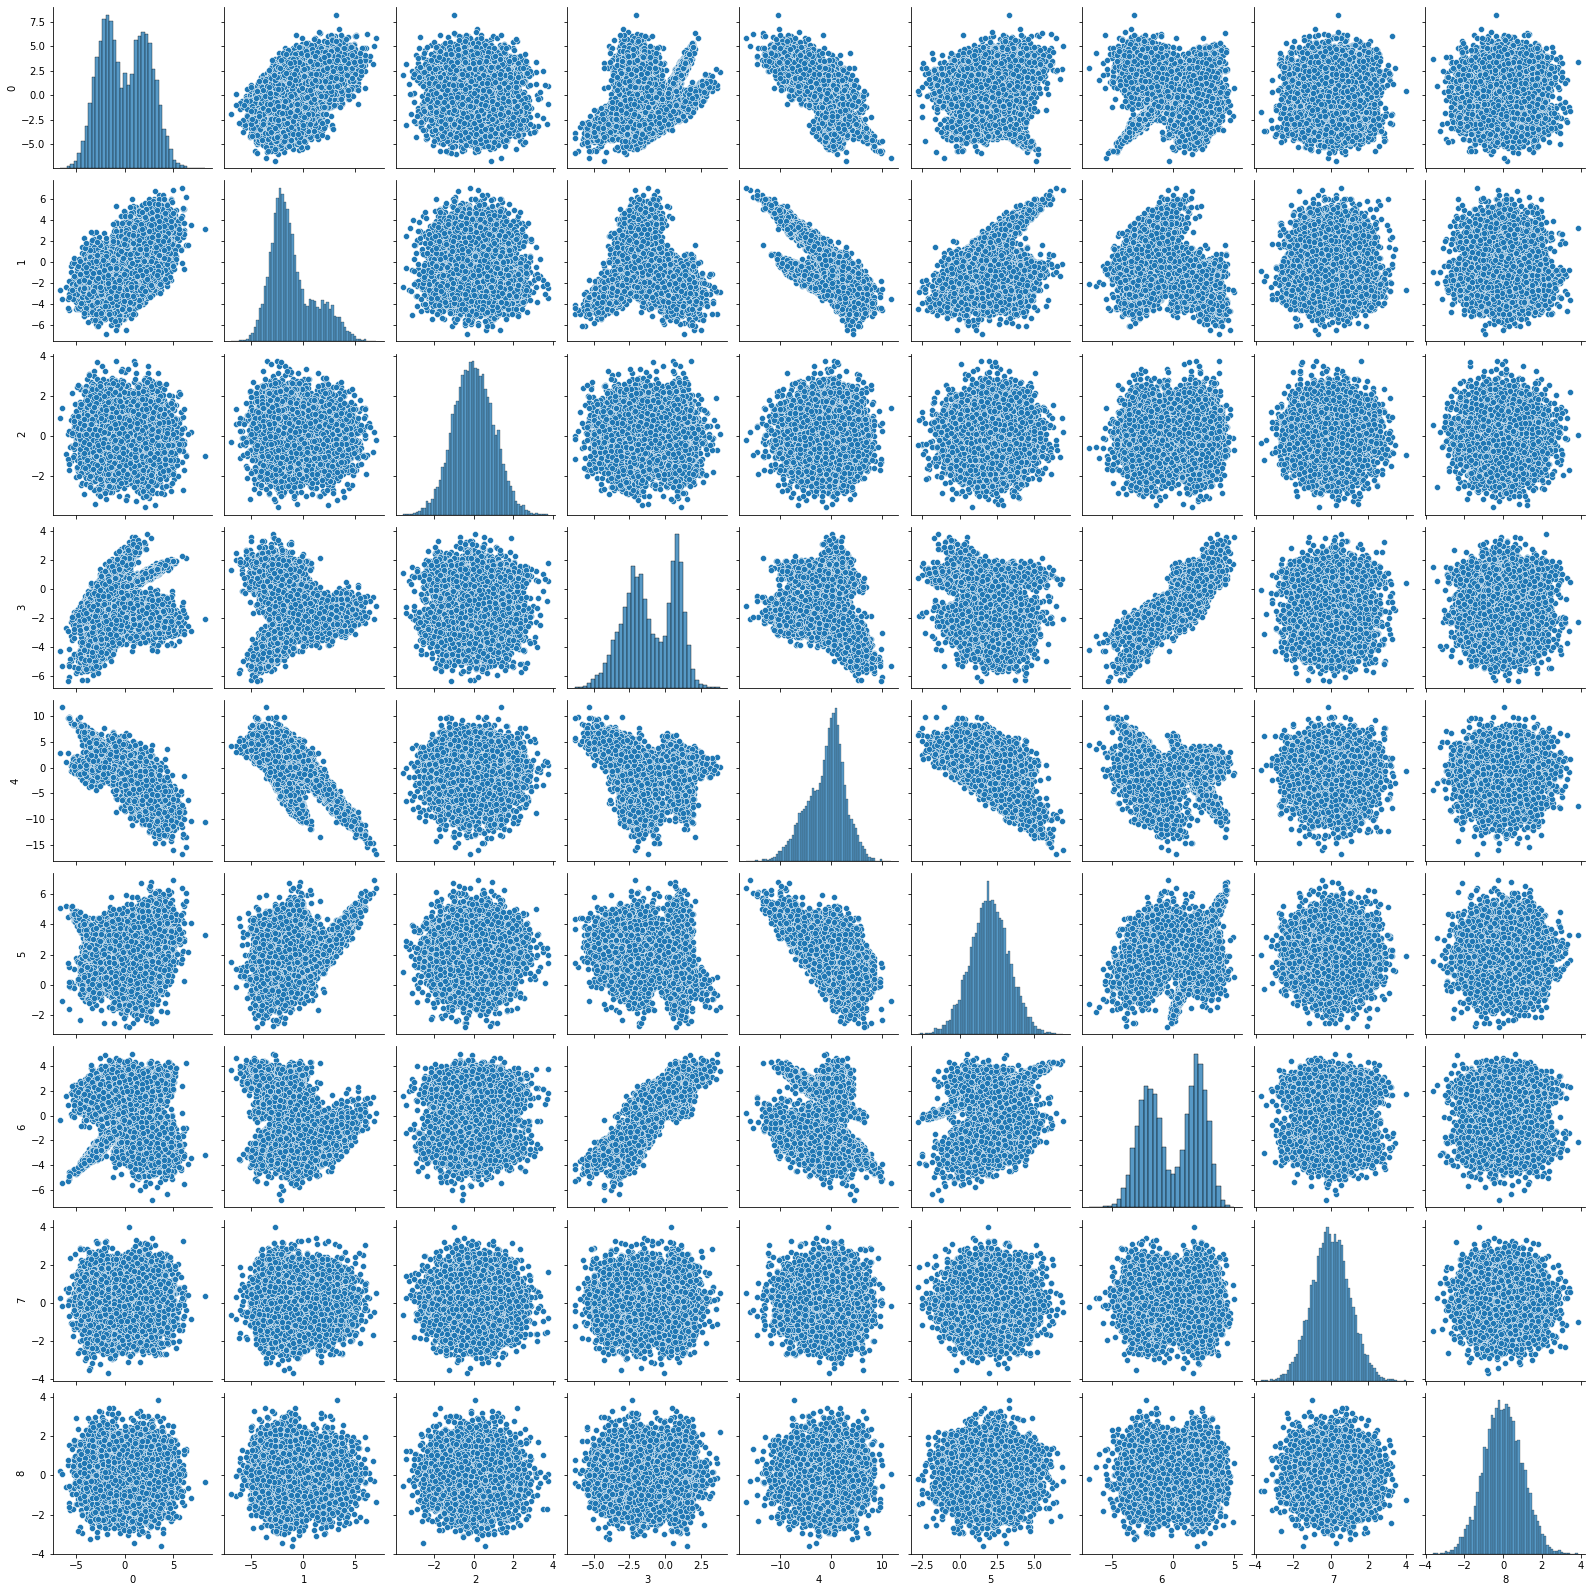

In [4]:
# Her özellik için verileri görselleştirin (pairplot, distplot)
import matplotlib.pyplot as plt
import seaborn as sns

# Pairplot
sns.pairplot(featuresDf)

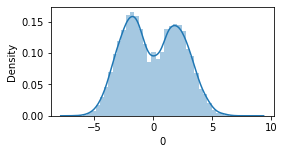

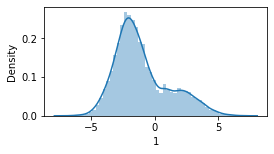

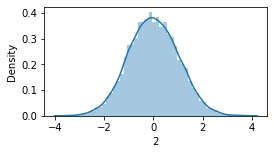

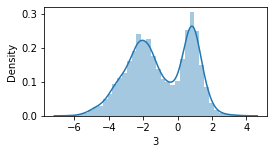

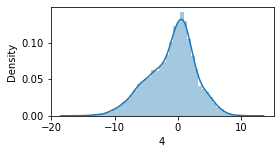

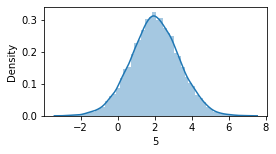

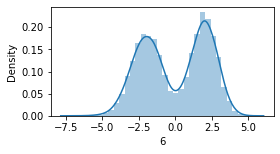

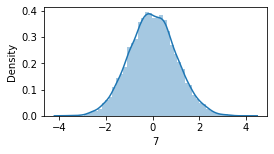

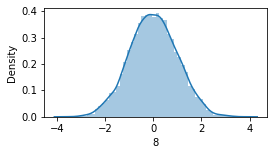

In [5]:
# Distplot for each column
for col in featuresDf.columns:
    plt.figure(figsize=(4, 2))
    sns.distplot(featuresDf[col])
    plt.show()

(9.5, -0.5)

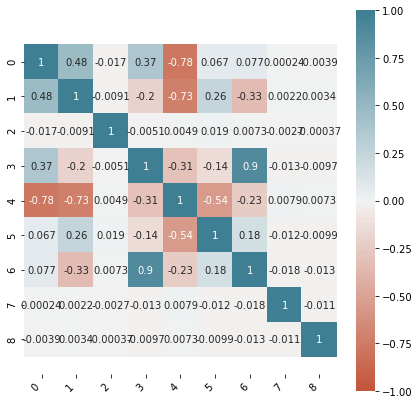

In [6]:
# Korelasyon matrisi çizin.
correlation_matrix = featuresDf.corr()

plt.figure(figsize=(7, 7))
ax = sns.heatmap(
    correlation_matrix, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, annot=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.set_ylim(len(correlation_matrix)+0.5, -0.5)

`3` ve `6` öznitelikleri korele gözüküyor.

In [7]:
# Korele 3 ve 6 özniteliklerinden birini eleyelim.
featuresDf.drop([6], axis=1, inplace=True)
X = featuresDf.values

In [8]:
# Aykırı değerleri işleyin (IsolationForest, Z-score, IQR kullanabilirsiniz)
from scipy import stats

zScores = np.abs(stats.zscore(featuresDf))
outlierIndexes = list(set(np.where(zScores > 3)[0]))
print("Outlier count:", len(outlierIndexes))

# Delete outlier rows from matrices
X = np.delete(X, outlierIndexes, axis=0)
y = np.delete(y, outlierIndexes, axis=0)

print(X.shape)
print(y.shape)

Outlier count: 132
(9868, 8)
(9868,)


In [9]:
# Scaling
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)
print(X.shape)
print(y.shape)

(9868, 8)
(9868,)


In [10]:
# Veri kümesini eğitim ve test verisetlerine ayırın.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=(42*24*44*22))

In [11]:
# Karar Ağacını içe aktarın, farklı hiperparametreleri deneyerek algoritmayı ayarlayın. (hyperpara)
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

hyperparams = {
    "max_depth": range(3, 15),
    "min_samples_split": range(2, 25, 5)
}

decisionTreeModel = GridSearchCV(
    DecisionTreeClassifier(),
    param_grid=hyperparams,
    cv=3,
    n_jobs=-1
)
decisionTreeModel.fit(X_train, y_train)

print("Best parameters:", decisionTreeModel.best_params_)
print("Train score {0:.6f}, Test score {1:.6f}".format(
    decisionTreeModel.score(X_train, y_train),
    decisionTreeModel.score(X_test, y_test)
))

Best parameters: {'max_depth': 8, 'min_samples_split': 2}
Train score 0.990155, Test score 0.975008


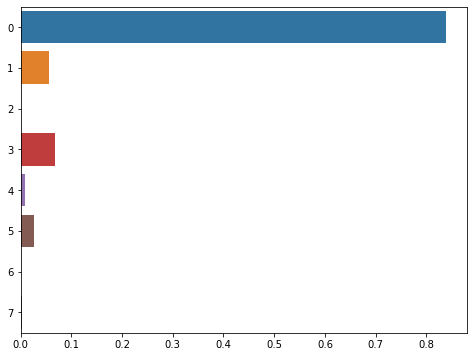

In [12]:
# Öznitelik önemlerini (feature importances) görselleştirin.
plt.figure(figsize=(8, 6))
sns.barplot(
    x=decisionTreeModel.best_estimator_.feature_importances_,
    y=[str(f) for f in list(range(X.shape[1]))]
)
plt.show()

In [13]:
# Hata matrisini oluşturun ve accuracy, recall, precision ve f1-score değerlerini hesaplayın.
from sklearn.metrics import classification_report
print(classification_report(y_train, decisionTreeModel.predict(X_train)))
print(classification_report(y_test, decisionTreeModel.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3393
           1       0.99      0.99      0.99      3514

    accuracy                           0.99      6907
   macro avg       0.99      0.99      0.99      6907
weighted avg       0.99      0.99      0.99      6907

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1507
           1       0.98      0.97      0.97      1454

    accuracy                           0.98      2961
   macro avg       0.98      0.97      0.97      2961
weighted avg       0.98      0.98      0.98      2961



In [14]:
# XGBoostClassifier'ı içe aktarın, farklı hiperparametreleri deneyerek algoritmayı ayarlayın.
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV

hyperparams = {
    "max_depth": [3, 5, 7, 12],
    "learning_rate": [0.0001, 0.001, 0.01, 1, 2],
    "n_estimators": [10, 100, 150, 300],
}

xgc = XGBClassifier(
    booster="gbtree",
    objective="binary:logistic",
    n_jobs=-1
)

XGBoostModel = GridSearchCV(
    xgc,
    param_grid=hyperparams,
    cv=3,
    n_jobs=-1
)
XGBoostModel.fit(X_train, y_train, eval_metric="logloss")

print("Best parameters:", XGBoostModel.best_params_)
print("Train score {0:.6f}, Test score {1:.6f}".format(
    XGBoostModel.score(X_train, y_train),
    XGBoostModel.score(X_test, y_test)
))

Best parameters: {'learning_rate': 1, 'max_depth': 5, 'n_estimators': 100}
Train score 1.000000, Test score 0.985140


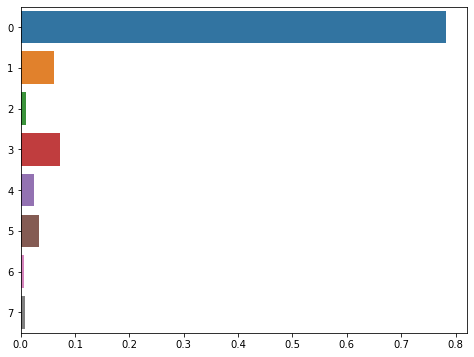

In [15]:
# Öznitelik önemlerini (feature importances) görselleştirin.
plt.figure(figsize=(8, 6))
sns.barplot(
    x=XGBoostModel.best_estimator_.feature_importances_,
    y=[str(f) for f in list(range(X.shape[1]))]
)
plt.show()

In [16]:
# Hata matrisini oluşturun ve accuracy, recall, precision ve f1-score değerlerini hesaplayın.
from sklearn.metrics import classification_report
print(classification_report(y_train, XGBoostModel.predict(X_train)))
print(classification_report(y_test, XGBoostModel.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3393
           1       1.00      1.00      1.00      3514

    accuracy                           1.00      6907
   macro avg       1.00      1.00      1.00      6907
weighted avg       1.00      1.00      1.00      6907

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1507
           1       0.99      0.98      0.98      1454

    accuracy                           0.99      2961
   macro avg       0.99      0.99      0.99      2961
weighted avg       0.99      0.99      0.99      2961



In [17]:
print("DecisionTree, Best parameters:", decisionTreeModel.best_params_)
print(classification_report(y_test, decisionTreeModel.predict(X_test)))
print("XGBoostClassifier, Best parameters:", XGBoostModel.best_params_)
print(classification_report(y_test, XGBoostModel.predict(X_test)))

DecisionTree, Best parameters: {'max_depth': 8, 'min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1507
           1       0.98      0.97      0.97      1454

    accuracy                           0.98      2961
   macro avg       0.98      0.97      0.97      2961
weighted avg       0.98      0.98      0.98      2961

XGBoostClassifier, Best parameters: {'learning_rate': 1, 'max_depth': 5, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1507
           1       0.99      0.98      0.98      1454

    accuracy                           0.99      2961
   macro avg       0.99      0.99      0.99      2961
weighted avg       0.99      0.99      0.99      2961



##### Sonucunuzu değerlendirin ve veri setimiz için en iyi performans gösteren algoritmayı seçin.
`XGBoostClassifier` modeli birden fazla estimator kullanarak çıktı verdiği için, `DecisionTree` kullanılarak sadece bir ağaç üzerinde hiperparametre aramasıyla oluşan modelden doğal olarak daha iyi sonuç veriyor.

https://i.kym-cdn.com/entries/icons/facebook/000/031/254/cover3.jpg